In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from src.utils import peak_normalise
from pedalboard.pedalboard import load_plugin

from src.dataset.paired_audio_dataset import PairedAudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

from src.models.style_transfer_vae import StyleTransferVAE
import seaborn as sns

sns.set()

In [15]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
DAFX_NAME = "mda RingMod"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES_PER_SETTING = 500
NUM_SETTINGS = 20
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_style_vae/3kdv9ddi/checkpoints/epoch=820-step=513125.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]

In [16]:
def dafx_from_name(dafx_name):
    if dafx_name.lower() == "clean":
        return NullDAFXWrapper()
    dafx = load_plugin(DAFX_FILE, plugin_name=dafx_name)
    return DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [17]:
def get_dataset(dafx):
    dataset = PairedAudioDataset(
        dafx=dafx,
        audio_dir=AUDIO_DIR,
        subset="train",
        input_dirs=DATASETS,
        num_examples_per_epoch=NUM_EXAMPLES_PER_SETTING,
        augmentations={},
        length=131_072,
        effect_input=False,
        effect_output=True,
        dummy_setting=True
    )

    return torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=1,
        timeout=6000,
    )

In [18]:
def audio_to_spectrogram(signal: torch.Tensor,
                         n_fft: int = 4096,
                         hop_length: int = 2048,
                         window_size: int = 4096):

    bs, _, _ = signal.size()

    signal = peak_normalise(signal)

    window = torch.hann_window(window_size).to(signal.device)

    X = torch.stft(
        signal.view(bs, -1),
        n_fft=n_fft,
        hop_length=hop_length,
        window=window,
        return_complex=True,
    )

    # Absolute value part
    X_db = torch.pow(X.abs() + 1e-8, 0.3)

    # Normalise (0,1)
    X_db_norm = (X_db - X_db.mean()) / X_db.std()

    X_db_norm = X_db_norm.unsqueeze(1).permute(0, 1, 3, 2)

    return X_db_norm

In [19]:
dafx = dafx_from_name(DAFX_NAME)

In [20]:
dataset = get_dataset(dafx_from_name('clean'))

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 25678.22it/s]


Loaded 88 files for train = 66.89 hours.


In [21]:
x, y = next(iter(dataset))

In [22]:
Audio(x.numpy().squeeze(), rate=SAMPLE_RATE)

In [23]:
Audio(y.numpy().squeeze(), rate=SAMPLE_RATE)

In [24]:
dafx.param_names

['freq_hz', 'fine_hz', 'feedback']

In [44]:
y_quiet = dafx.apply(y, torch.ones(dafx.get_num_params()) *0.4)

In [45]:
# y_loud = dafx.apply(y, torch.Tensor([0.5, 0.5, 0.7]))

In [46]:
Audio(y_quiet.numpy().squeeze(), rate=SAMPLE_RATE, normalize=True)

In [43]:
# Audio(y_loud.numpy().squeeze(), rate=SAMPLE_RATE, normalize=False)

In [16]:
y_quiet_norm = peak_normalise(y_quiet)
y_loud_norm = peak_normalise(y_loud)

In [17]:
y_quiet_norm

tensor([0.0000, 0.0002, 0.0003,  ..., 0.0018, 0.0016, 0.0014])

In [18]:
y_loud_norm

tensor([0.0012, 0.0011, 0.0012,  ..., 0.0018, 0.0016, 0.0014])

In [19]:
np.allclose(y_quiet_norm, y_loud_norm, atol=.001)

False

In [20]:
Audio(x.numpy().squeeze(), rate=SAMPLE_RATE, normalize=False)

In [21]:
Audio(y_quiet_norm.numpy().squeeze(), rate=SAMPLE_RATE, normalize=False)

In [22]:
Audio(y_loud_norm.numpy().squeeze(), rate=SAMPLE_RATE, normalize=False)

In [23]:
model = StyleTransferVAE.load_from_checkpoint(CHECKPOINT)
model.eval()
model.to("cuda")

StyleTransferVAE(
  (encoder_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mu): Linear(in_features=20640, out_features=4096, bias=True)
  (log_var): Linear(in_features=2064

In [24]:
x.shape

torch.Size([1, 1, 131072])

In [25]:
y_quiet.shape

torch.Size([131072])

In [26]:
X_quiet = torch.torch.concat(
    [audio_to_spectrogram(x),
     audio_to_spectrogram(y_quiet.unsqueeze(0).unsqueeze(0))
     ],
    dim=1).to("cuda")

In [27]:
X_loud = torch.torch.concat(
    [audio_to_spectrogram(x),
     audio_to_spectrogram(y_loud.unsqueeze(0).unsqueeze(0))
     ],
    dim=1).to("cuda")

In [28]:
X_norm = torch.torch.concat(
    [audio_to_spectrogram(x),
     audio_to_spectrogram(y_quiet_norm.unsqueeze(0).unsqueeze(0))
     ],
    dim=1).to("cuda")

In [29]:
X_quiet_hat, _, _, _ = model(X_quiet)

In [30]:
X_loud_hat, _, _, _ = model(X_loud)

In [31]:
X_norm_hat, _, _, _ = model(X_norm)

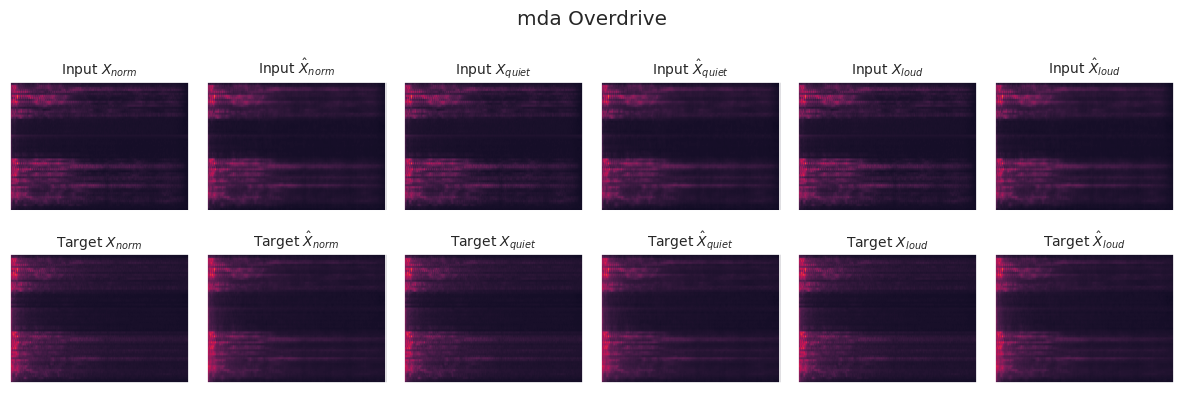

In [32]:
fig, axes = plt.subplots(2, 6, figsize=(12,4))

spectrograms = [X_norm, X_norm_hat, X_quiet, X_quiet_hat, X_loud, X_loud_hat]
row_labels = ["$X_{norm}$", "$\hat{X}_{norm}$", "$X_{quiet}$", "$\hat{X}_{quiet}$", "$X_{loud}$", "$\hat{X}_{loud}$"]

minmin = min([torch.min(X).item() for X in spectrograms])
maxmax = max([torch.max(X).item() for X in spectrograms])

for i, X in enumerate(spectrograms):
    X = X.cpu()

    ax1 = axes[0, i].imshow(X[0,0,:,:].detach().squeeze().numpy(),
                                aspect='auto',
                                vmin=minmin,
                                vmax=maxmax
                                )

    ax2 = axes[1, i].imshow(X[0,1,:,:].detach().squeeze().numpy(),
                            aspect='auto',
                            vmin=minmin,
                            vmax=maxmax
                            )

    axes[0, i].set_title(f"Input {row_labels[i]}", fontsize=10)
    axes[1, i].set_title(f"Target {row_labels[i]}", fontsize=10)

    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])

fig.suptitle(DAFX_NAME)

plt.tight_layout()
plt.savefig(f"./figures/spec_norm_test/{CHECKPOINT_ID}_{DAFX_NAME.split()[-1]}_recons.png")


## Interpolate DB

In [33]:
n_subplots = 8
db_settings = np.linspace(0,1, n_subplots)
x, y = next(iter(dataset))

In [34]:
x_spec = audio_to_spectrogram(x)
embeddings = []
setting_spectogram_pairs = []
spectrogram_target_recons = []
effected_audio = []

for i, setting in enumerate(db_settings):
    y_effected = dafx.apply(y, torch.Tensor([0.5, 0.5, i]))
    y_effected = y_effected.unsqueeze(0).unsqueeze(0)

    y_spec = audio_to_spectrogram(y_effected)

    X = torch.concat([x_spec, y_spec], dim=1).to("cuda")
    X_hat, _, _, z = model(X)

    embeddings.append(z.cpu().detach().numpy())
    effected_audio.append(y_effected.squeeze().cpu().detach().numpy())
    setting_spectogram_pairs.append((setting, y_spec.cpu().detach()))
    spectrogram_target_recons.append(X_hat[:,1,:,:].unsqueeze(1).cpu().detach())


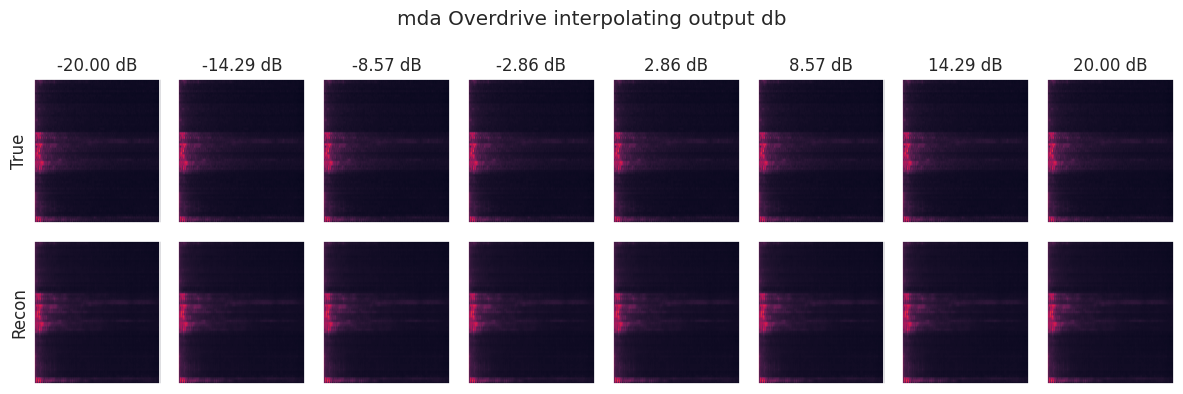

In [35]:
fig, axs = plt.subplots(2, n_subplots, figsize=(12, 4))

minmin = min([torch.min(X[1]).item() for X in setting_spectogram_pairs])
maxmax = max([torch.max(X[1]).item() for X in setting_spectogram_pairs])

for i, batch in enumerate(setting_spectogram_pairs):
    setting, X = batch
    X_hat = spectrogram_target_recons[i]

    axs[0, i].imshow(X[0,0,:,:].detach().squeeze().numpy(),
                                aspect='auto',
                                vmin=minmin,
                                vmax=maxmax
                                )

    axs[1, i].imshow(X_hat[0,0,:,:].detach().squeeze().numpy(),
                                aspect='auto',
                                vmin=minmin,
                                vmax=maxmax
                                )

    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])

    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

    denormalised_setting = dafx._denormalise('output_db', setting)
    axs[0, i].set_title(f"{denormalised_setting:.2f} dB")

axs[0,0].set_ylabel("True")
axs[1,0].set_ylabel("Recon")


fig.suptitle(f"{DAFX_NAME} interpolating output db")
plt.tight_layout()

plt.savefig(f"./figures/spec_norm_test/{CHECKPOINT_ID}_{DAFX_NAME.split()[-1]}_interpolate.png")

## Audio similarity

In [36]:
audio_data = np.array(effected_audio)

In [37]:
normalised_audio_data = ([peak_normalise(torch.Tensor(x)).numpy() for x in effected_audio])

In [38]:
from scipy.spatial.distance import pdist, squareform

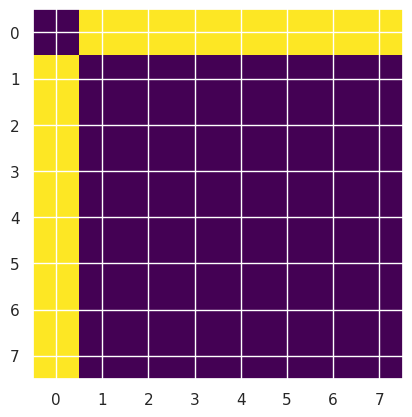

In [39]:
distances = pdist(audio_data)
distance_matrix = squareform(distances)

plt.imshow(distance_matrix, cmap='viridis')
plt.show()

## Distances

In [40]:
data = np.array(embeddings).squeeze()

In [41]:
data.shape

(8, 4096)

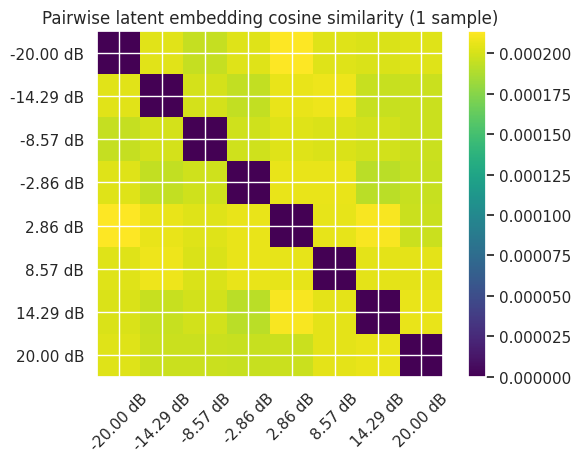

In [42]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

metric = 'cosine'

# Compute pairwise Euclidean distances
distances = pdist(data, metric=metric)

# Convert distances to a square matrix
distance_matrix = squareform(distances)

# Create heatmap
ax = plt.imshow(distance_matrix, cmap='viridis')

labels = [f"{dafx._denormalise('output_db', setting):.2f} dB" for setting in db_settings]

plt.xticks(range(8), labels, rotation=45)
plt.yticks(range(8), labels)

plt.title("Pairwise latent embedding cosine similarity (1 sample)")

plt.colorbar()

plt.tight_layout()

plt.savefig(f"./figures/spec_norm_test/{CHECKPOINT_ID}_{DAFX_NAME.split()[-1]}_{metric}.png")

In [43]:
from tqdm import tqdm

dataset = get_dataset(dafx_from_name('clean'))

embeds = []

for setting in db_settings:
    print("Applying dB setting: ", setting)
    embeddings = []
    for batch in tqdm(dataset):
        x, y = batch

        # Apply setting to audio
        y_effected = dafx.apply(y, torch.Tensor([0.5, 0.5, setting]))

        x_s = audio_to_spectrogram(signal=x)
        y_s = audio_to_spectrogram(signal=y)

        X = torch.concat([x_s, y_s], dim=1).to("cuda")

        _, _, _, z = model(X)

        embeddings.append(z.cpu().detach().numpy())

    embeds.append((setting, np.array(embeddings)))


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 43706.19it/s]



Loaded 88 files for train = 66.89 hours.
Applying dB setting:  0.0


100%|██████████| 500/500 [00:06<00:00, 77.05it/s] 


Applying dB setting:  0.14285714285714285


100%|██████████| 500/500 [00:06<00:00, 78.39it/s] 


Applying dB setting:  0.2857142857142857


100%|██████████| 500/500 [00:06<00:00, 78.68it/s] 


Applying dB setting:  0.42857142857142855


100%|██████████| 500/500 [00:06<00:00, 79.30it/s] 


Applying dB setting:  0.5714285714285714


100%|██████████| 500/500 [00:06<00:00, 77.41it/s] 


Applying dB setting:  0.7142857142857142


100%|██████████| 500/500 [00:06<00:00, 76.94it/s] 


Applying dB setting:  0.8571428571428571


100%|██████████| 500/500 [00:06<00:00, 75.93it/s] 


Applying dB setting:  1.0


100%|██████████| 500/500 [00:06<00:00, 76.50it/s] 


In [44]:
for i, e in embeds:
    print(e.shape)


(500, 1, 4096)
(500, 1, 4096)
(500, 1, 4096)
(500, 1, 4096)
(500, 1, 4096)
(500, 1, 4096)
(500, 1, 4096)
(500, 1, 4096)


In [45]:
mean_embeddings = []

for setting, embeddings in embeds:
    m_e = np.mean(embeddings, axis=0)
    mean_embeddings.append((setting, m_e))


In [46]:
mean_data = np.array([i[1] for i in mean_embeddings]).squeeze()
mean_vector_settings = [i[0] for i in mean_embeddings]

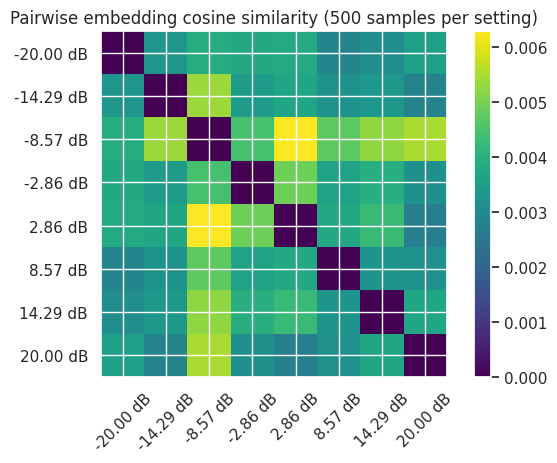

In [47]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

metric = 'cosine'

# Compute pairwise Euclidean distances
distances = pdist(mean_data, metric=metric)

# Convert distances to a square matrix
distance_matrix = squareform(distances)

# Create heatmap
ax = plt.imshow(distance_matrix, cmap='viridis')

labels = [f"{dafx._denormalise('output_db', setting):.2f} dB" for setting in mean_vector_settings]

plt.xticks(range(8), labels, rotation=45)
plt.yticks(range(8), labels)

plt.title("Pairwise embedding cosine similarity (500 samples per setting)")


plt.colorbar()

plt.tight_layout()

plt.savefig(f"./figures/spec_norm_test/{CHECKPOINT_ID}_{DAFX_NAME.split()[-1]}_{metric}_mean.png")